In [91]:
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import random
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt

In [174]:
def load_data(dataset_name, test_size=0.2, random_state=1):
    class Object(object):
        pass
    if dataset_name == 'mnist':
        data = load_digits()
    elif dataset_name == 'breast_cancer':
        data = load_breast_cancer()
    elif dataset_name == 'iris':
        data = load_iris()
    elif dataset_name == 'wine':
        data = load_wine()
    elif dataset_name == 'abalone':
        df = pd.read_csv('data/abalone.csv')
        df['Sex'] = df['Sex'].apply(lambda x: 0 if x=='M' else 1)
        labels = []
        for r in df['Rings']:
            if 0<=r and r<=7:
                label = 1
            elif 8<=r and r<=10:
                label = 2
            elif 11<=r and r<=15:
                label = 3
            elif r>15:
                label = 4
            labels.append(label)
        data = Object()
        data.data = np.asarray(df.loc[:, df.columns!='Rings'])
        data.target = np.asarray(labels)
    elif dataset_name == 'synthetic':
        df = pd.read_csv('data/synth_data.csv')
        df = pd.get_dummies(df, prefix=['a', 'b', 'c'])
        data = Object()
        data.data = np.asarray(df.loc[:, df.columns!='label'])
        data.target = np.asarray(df['label'])
    X = data.data
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print('Train: ', X_train.shape, ' | Test: ', X_test.shape)
    print('Train labels: ', np.unique(y_train, return_counts=True))
    print('Test labels: ', np.unique(y_test, return_counts=True))
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = load_data('mnist', test_size=0.2)
X_train, X_test, y_train, y_test = load_data('abalone', test_size=0.2)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

Train:  (3341, 8)  | Test:  (836, 8)
Train labels:  (array([1, 2, 3, 4]), array([ 672, 1509,  948,  212]))
Test labels:  (array([1, 2, 3, 4]), array([167, 382, 238,  49]))


In [216]:
from sklearn.ensemble import BaggingClassifier
bagging_accs = []
for i in range(100):
    clf = BaggingClassifier()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    bagging_accs.append(accuracy_score(y_test, preds))
print(sum(bagging_accs)/100)

/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected

/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected

/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected

/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected

0.5856339712918669


/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [218]:
dec_tree_accs = []
for i in range(100):
    clf = DecisionTreeClassifier(min_samples_leaf=10)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    dec_tree_accs.append(accuracy_score(y_test, preds))
print(sum(dec_tree_accs)/100)    

0.582571770334929


In [220]:
n_iter = 50
acc_threshold = 0.8
pop_size = X_train.shape[0]
add_size = 50
# bad_idx = pd.DataFrame({'index': X_train.index, 'reject_count': [0]*pop_size})
n_biomes = 10
initial_size = 100
voting_accs = []
stacking_accs = []
for t in range(10):
    # create initial biomes
    biomes = []
    permuted_indices = np.random.permutation(pop_size)
    for i in range(n_biomes):
        biome_idx = random.choices(y_train.index, k=initial_size)
        temp_X = X_train.loc[biome_idx, :]
        temp_y = y_train.loc[biome_idx, :]
        biomes.append({'X': temp_X, 'y': temp_y})
    all_iter_acc = []
    for it in range(n_iter):
        iter_acc = []
        iter_bag_size = []
        for i, biome in enumerate(biomes):
    #         biome['clf'] = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
            class_weight = {}
            if len(np.unique(biome['y'][0])) == 10:
                for j in range(10):
                    if j!= i:
                        class_weight[j] = 1
                    else:
                        class_weight[j] = 2
            biome['clf'] = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, class_weight=class_weight)        
            biome['clf'].fit(biome['X'], biome['y'])
            preds = biome['clf'].predict(biome['X'])
            acc = accuracy_score(biome['y'][0], preds)
            # extract good part and bad part
            good_part_X = biome['X'].loc[preds == biome['y'][0], :]
            good_part_y = biome['y'].loc[preds == biome['y'][0], :]
            bad_part_X = biome['X'].loc[preds != biome['y'][0], :]
            bad_part_y = biome['y'].loc[preds != biome['y'][0], :]
            # get new part
            if acc > acc_threshold and len(set(biome['X'].index)) < pop_size/2:
                biome_complement_idx = list(set(X_train.index) - set(biome['X'].index))
                new_idx = random.choices(biome_complement_idx, k = add_size)
                new_part_X = X_train.loc[new_idx, :]
                new_part_y = y_train.loc[new_idx, :]
                biome['X'] = pd.concat([biome['X'], new_part_X])
                biome['y'] = pd.concat([biome['y'], new_part_y])
            elif acc > acc_threshold and len(set(biome['X'].index)) < pop_size/2:
                pass
            else:
                biome['X'] = good_part_X
                biome['y'] = good_part_y
            iter_acc.append(round(acc*100, 1))
            iter_bag_size.append(biome['X'].shape[0])
    #     print(iter_bag_size)
    #     print(iter_acc)
        all_iter_acc.append(iter_acc)
    print('==========================================================================')
    final_acc = []
    final_depth = []
    final_leaves = []
    final_biome_size = []
    idx_set = set()
    class_acc = np.zeros((n_biomes, len(np.unique(y_test))))
    for i, biome in enumerate(biomes):
        preds = biome['clf'].predict(X_test)
        acc = accuracy_score(y_test, preds)
        final_acc.append(round(acc*100, 1))
        cm = confusion_matrix(y_test, preds)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        class_acc[i, :] = cm.diagonal()
        final_depth.append(biome['clf'].get_depth())
        final_leaves.append(biome['clf'].get_n_leaves())
        final_biome_size.append(biome['X'].shape[0])
        idx_set.update(biome['X'].index)
    print('Final size:  ', final_biome_size)
    print('Final acc:   ', final_acc)
    print('Final depth: ', final_depth)
    print('Final leaves:', final_leaves)
    print('Cover: ', len(idx_set)/pop_size)
    preds_list = []
    for biome in biomes:
        preds_list.append(biome['clf'].predict(X_test))
    scores = np.zeros((len(preds_list), len(preds_list)))
    for i in range(len(preds_list)):
        for j in range(len(preds_list)):
            scores[i, j] = round(sum(preds_list[i] == preds_list[j])/len(preds_list[0]), 2)
    print(scores)
    from scipy import stats
    temp_preds = np.stack(preds_list)
    final_preds = stats.mode(temp_preds).mode[0]
    voting_acc = accuracy_score(y_test, final_preds)
    print('Voting accuracy: ', voting_acc)
    # stacking
    from sklearn.linear_model import LogisticRegression
    meta_X_train = np.zeros((len(y_train), n_biomes))
    meta_X_test = np.zeros((len(y_test), n_biomes))
    for i, biome in enumerate(biomes):
        meta_X_train[:, i] = biome['clf'].predict(X_train)
        meta_X_test[:, i] = biome['clf'].predict(X_test)
    meta_clf = LogisticRegression()
    meta_clf.fit(meta_X_train, y_train)
    # print(meta_clf.get_depth(), meta_clf.get_n_leaves())
    meta_preds = meta_clf.predict(meta_X_test)
    meta_acc = accuracy_score(y_test, meta_preds)
    print('Stacking accuracy: ', meta_acc)
    voting_accs.append(voting_acc)
    stacking_accs.append(meta_acc)
print('Average voting accuracy: ', sum(voting_accs)/10)
print('Average stacking accuracy: ', sum(stacking_accs)/10)

Final size:   [1659, 1610, 1604, 1538, 1650, 1423, 1371, 1336, 1411, 1411]
Final acc:    [59.6, 58.3, 61.1, 59.8, 58.6, 60.3, 57.7, 58.1, 60.0, 57.4]
Final depth:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 9]
Final leaves: [96, 89, 93, 94, 99, 70, 109, 100, 54, 47]
Cover:  0.97395989224783
[[1.   0.76 0.77 0.76 0.79 0.77 0.76 0.79 0.72 0.76]
 [0.76 1.   0.72 0.71 0.74 0.74 0.72 0.77 0.7  0.72]
 [0.77 0.72 1.   0.74 0.77 0.79 0.77 0.78 0.74 0.73]
 [0.76 0.71 0.74 1.   0.7  0.75 0.74 0.76 0.73 0.7 ]
 [0.79 0.74 0.77 0.7  1.   0.77 0.75 0.77 0.75 0.75]
 [0.77 0.74 0.79 0.75 0.77 1.   0.77 0.79 0.73 0.78]
 [0.76 0.72 0.77 0.74 0.75 0.77 1.   0.79 0.73 0.74]
 [0.79 0.77 0.78 0.76 0.77 0.79 0.79 1.   0.75 0.75]
 [0.72 0.7  0.74 0.73 0.75 0.73 0.73 0.75 1.   0.71]
 [0.76 0.72 0.73 0.7  0.75 0.78 0.74 0.75 0.71 1.  ]]
Voting accuracy:  0.6064593301435407


/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking accuracy:  0.6052631578947368
Final size:   [1558, 1684, 1549, 1424, 1477, 1501, 1439, 1542, 1462, 1581]
Final acc:    [58.6, 57.9, 60.4, 60.0, 57.5, 58.9, 60.5, 59.4, 58.4, 56.3]
Final depth:  [10, 10, 10, 9, 10, 10, 10, 10, 10, 10]
Final leaves: [80, 98, 86, 42, 69, 75, 64, 86, 81, 82]
Cover:  0.9760550733313379
[[1.   0.71 0.75 0.72 0.7  0.72 0.73 0.71 0.7  0.64]
 [0.71 1.   0.79 0.75 0.76 0.76 0.78 0.73 0.75 0.72]
 [0.75 0.79 1.   0.81 0.79 0.8  0.78 0.76 0.81 0.74]
 [0.72 0.75 0.81 1.   0.75 0.78 0.78 0.73 0.79 0.75]
 [0.7  0.76 0.79 0.75 1.   0.74 0.74 0.71 0.75 0.7 ]
 [0.72 0.76 0.8  0.78 0.74 1.   0.76 0.75 0.76 0.7 ]
 [0.73 0.78 0.78 0.78 0.74 0.76 1.   0.75 0.76 0.7 ]
 [0.71 0.73 0.76 0.73 0.71 0.75 0.75 1.   0.71 0.71]
 [0.7  0.75 0.81 0.79 0.75 0.76 0.76 0.71 1.   0.73]
 [0.64 0.72 0.74 0.75 0.7  0.7  0.7  0.71 0.73 1.  ]]
Voting accuracy:  0.6136363636363636


/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking accuracy:  0.6196172248803827
Final size:   [1712, 1666, 1432, 1650, 1531, 1484, 1523, 1324, 1553, 1394]
Final acc:    [59.0, 60.5, 57.9, 57.5, 59.6, 58.6, 58.4, 58.4, 58.9, 58.9]
Final depth:  [10, 10, 10, 10, 10, 10, 10, 9, 10, 10]
Final leaves: [97, 101, 58, 100, 76, 80, 83, 44, 87, 54]
Cover:  0.9766536964980544
[[1.   0.66 0.74 0.69 0.69 0.73 0.66 0.76 0.72 0.71]
 [0.66 1.   0.74 0.75 0.76 0.72 0.72 0.77 0.72 0.72]
 [0.74 0.74 1.   0.73 0.77 0.74 0.72 0.79 0.75 0.72]
 [0.69 0.75 0.73 1.   0.73 0.7  0.71 0.73 0.7  0.69]
 [0.69 0.76 0.77 0.73 1.   0.75 0.75 0.79 0.79 0.72]
 [0.73 0.72 0.74 0.7  0.75 1.   0.71 0.75 0.74 0.73]
 [0.66 0.72 0.72 0.71 0.75 0.71 1.   0.73 0.75 0.7 ]
 [0.76 0.77 0.79 0.73 0.79 0.75 0.73 1.   0.78 0.76]
 [0.72 0.72 0.75 0.7  0.79 0.74 0.75 0.78 1.   0.75]
 [0.71 0.72 0.72 0.69 0.72 0.73 0.7  0.76 0.75 1.  ]]
Voting accuracy:  0.6052631578947368


/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking accuracy:  0.6196172248803827
Final size:   [1354, 1415, 1580, 1310, 1255, 1571, 1520, 1548, 1545, 1565]
Final acc:    [59.3, 57.5, 57.8, 60.5, 59.4, 57.8, 58.9, 60.2, 58.1, 59.7]
Final depth:  [10, 9, 10, 10, 10, 10, 10, 10, 10, 10]
Final leaves: [49, 44, 97, 50, 94, 96, 76, 88, 85, 90]
Cover:  0.9748578269979048
[[1.   0.72 0.74 0.77 0.73 0.74 0.78 0.78 0.74 0.73]
 [0.72 1.   0.72 0.77 0.72 0.75 0.76 0.74 0.68 0.76]
 [0.74 0.72 1.   0.73 0.69 0.74 0.76 0.74 0.72 0.7 ]
 [0.77 0.77 0.73 1.   0.76 0.78 0.77 0.81 0.76 0.76]
 [0.73 0.72 0.69 0.76 1.   0.74 0.73 0.77 0.75 0.73]
 [0.74 0.75 0.74 0.78 0.74 1.   0.75 0.78 0.75 0.74]
 [0.78 0.76 0.76 0.77 0.73 0.75 1.   0.8  0.71 0.76]
 [0.78 0.74 0.74 0.81 0.77 0.78 0.8  1.   0.76 0.75]
 [0.74 0.68 0.72 0.76 0.75 0.75 0.71 0.76 1.   0.7 ]
 [0.73 0.76 0.7  0.76 0.73 0.74 0.76 0.75 0.7  1.  ]]
Voting accuracy:  0.6160287081339713


/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking accuracy:  0.604066985645933
Final size:   [1466, 1658, 1562, 1592, 1342, 1494, 1608, 1412, 1627, 1618]
Final acc:    [58.7, 56.8, 59.3, 59.4, 59.3, 59.2, 58.4, 59.0, 60.3, 57.8]
Final depth:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Final leaves: [68, 94, 86, 87, 100, 78, 89, 54, 98, 90]
Cover:  0.980544747081712
[[1.   0.74 0.75 0.75 0.72 0.75 0.74 0.75 0.78 0.73]
 [0.74 1.   0.68 0.72 0.68 0.71 0.72 0.72 0.73 0.7 ]
 [0.75 0.68 1.   0.72 0.68 0.75 0.75 0.75 0.72 0.76]
 [0.75 0.72 0.72 1.   0.69 0.73 0.73 0.7  0.73 0.72]
 [0.72 0.68 0.68 0.69 1.   0.67 0.71 0.68 0.74 0.69]
 [0.75 0.71 0.75 0.73 0.67 1.   0.73 0.75 0.75 0.72]
 [0.74 0.72 0.75 0.73 0.71 0.73 1.   0.73 0.73 0.77]
 [0.75 0.72 0.75 0.7  0.68 0.75 0.73 1.   0.74 0.73]
 [0.78 0.73 0.72 0.73 0.74 0.75 0.73 0.74 1.   0.74]
 [0.73 0.7  0.76 0.72 0.69 0.72 0.77 0.73 0.74 1.  ]]
Voting accuracy:  0.6052631578947368


/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking accuracy:  0.611244019138756
Final size:   [1379, 1488, 1626, 1635, 1396, 1534, 1588, 1610, 1408, 1554]
Final acc:    [56.5, 59.3, 56.9, 57.2, 59.4, 57.4, 55.6, 60.2, 58.0, 59.4]
Final depth:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Final leaves: [109, 74, 98, 92, 48, 77, 92, 87, 56, 88]
Cover:  0.9817419934151451
[[1.   0.77 0.73 0.72 0.74 0.75 0.76 0.75 0.73 0.73]
 [0.77 1.   0.73 0.72 0.75 0.75 0.71 0.76 0.71 0.73]
 [0.73 0.73 1.   0.71 0.73 0.72 0.74 0.75 0.73 0.72]
 [0.72 0.72 0.71 1.   0.72 0.72 0.72 0.74 0.7  0.71]
 [0.74 0.75 0.73 0.72 1.   0.71 0.75 0.73 0.7  0.7 ]
 [0.75 0.75 0.72 0.72 0.71 1.   0.71 0.74 0.72 0.71]
 [0.76 0.71 0.74 0.72 0.75 0.71 1.   0.72 0.68 0.72]
 [0.75 0.76 0.75 0.74 0.73 0.74 0.72 1.   0.75 0.77]
 [0.73 0.71 0.73 0.7  0.7  0.72 0.68 0.75 1.   0.7 ]
 [0.73 0.73 0.72 0.71 0.7  0.71 0.72 0.77 0.7  1.  ]]
Voting accuracy:  0.604066985645933


/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking accuracy:  0.5933014354066986
Final size:   [1603, 1457, 1432, 1540, 1321, 1562, 1390, 1278, 1577, 1393]
Final acc:    [58.5, 59.3, 59.4, 59.2, 58.6, 58.3, 56.3, 56.5, 59.7, 59.9]
Final depth:  [10, 10, 10, 10, 8, 10, 10, 10, 10, 10]
Final leaves: [93, 68, 46, 84, 39, 86, 68, 91, 88, 45]
Cover:  0.959892247829991
[[1.   0.76 0.79 0.73 0.77 0.74 0.77 0.74 0.75 0.77]
 [0.76 1.   0.79 0.7  0.74 0.68 0.74 0.69 0.72 0.72]
 [0.79 0.79 1.   0.75 0.76 0.76 0.77 0.75 0.76 0.79]
 [0.73 0.7  0.75 1.   0.71 0.74 0.72 0.72 0.75 0.75]
 [0.77 0.74 0.76 0.71 1.   0.71 0.73 0.75 0.74 0.71]
 [0.74 0.68 0.76 0.74 0.71 1.   0.73 0.72 0.75 0.74]
 [0.77 0.74 0.77 0.72 0.73 0.73 1.   0.69 0.75 0.71]
 [0.74 0.69 0.75 0.72 0.75 0.72 0.69 1.   0.72 0.75]
 [0.75 0.72 0.76 0.75 0.74 0.75 0.75 0.72 1.   0.74]
 [0.77 0.72 0.79 0.75 0.71 0.74 0.71 0.75 0.74 1.  ]]
Voting accuracy:  0.604066985645933


/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking accuracy:  0.6148325358851675
Final size:   [1339, 1586, 1598, 1615, 1644, 1247, 1582, 1414, 1567, 1615]
Final acc:    [57.5, 57.2, 55.6, 58.1, 55.4, 57.2, 59.7, 58.0, 59.8, 57.7]
Final depth:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Final leaves: [47, 98, 87, 95, 95, 100, 87, 73, 81, 94]
Cover:  0.9841364860820113
[[1.   0.71 0.72 0.73 0.73 0.71 0.77 0.72 0.75 0.77]
 [0.71 1.   0.75 0.73 0.72 0.66 0.73 0.75 0.72 0.76]
 [0.72 0.75 1.   0.73 0.7  0.67 0.75 0.73 0.73 0.72]
 [0.73 0.73 0.73 1.   0.71 0.7  0.73 0.73 0.71 0.75]
 [0.73 0.72 0.7  0.71 1.   0.68 0.76 0.74 0.73 0.78]
 [0.71 0.66 0.67 0.7  0.68 1.   0.72 0.69 0.73 0.69]
 [0.77 0.73 0.75 0.73 0.76 0.72 1.   0.76 0.77 0.76]
 [0.72 0.75 0.73 0.73 0.74 0.69 0.76 1.   0.74 0.74]
 [0.75 0.72 0.73 0.71 0.73 0.73 0.77 0.74 1.   0.74]
 [0.77 0.76 0.72 0.75 0.78 0.69 0.76 0.74 0.74 1.  ]]
Voting accuracy:  0.5980861244019139


/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking accuracy:  0.5765550239234449
Final size:   [1567, 1397, 1738, 1667, 1656, 1537, 1708, 1699, 1462, 1443]
Final acc:    [61.5, 59.4, 58.3, 57.9, 57.5, 58.1, 59.9, 57.5, 61.5, 56.6]
Final depth:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Final leaves: [84, 53, 106, 97, 96, 81, 103, 98, 65, 69]
Cover:  0.9910206524992518
[[1.   0.77 0.76 0.75 0.72 0.75 0.78 0.77 0.72 0.72]
 [0.77 1.   0.77 0.75 0.73 0.74 0.77 0.76 0.79 0.77]
 [0.76 0.77 1.   0.74 0.73 0.77 0.77 0.77 0.73 0.73]
 [0.75 0.75 0.74 1.   0.75 0.75 0.75 0.75 0.73 0.73]
 [0.72 0.73 0.73 0.75 1.   0.77 0.78 0.73 0.71 0.72]
 [0.75 0.74 0.77 0.75 0.77 1.   0.76 0.72 0.72 0.74]
 [0.78 0.77 0.77 0.75 0.78 0.76 1.   0.75 0.76 0.74]
 [0.77 0.76 0.77 0.75 0.73 0.72 0.75 1.   0.72 0.72]
 [0.72 0.79 0.73 0.73 0.71 0.72 0.76 0.72 1.   0.7 ]
 [0.72 0.77 0.73 0.73 0.72 0.74 0.74 0.72 0.7  1.  ]]
Voting accuracy:  0.6064593301435407


/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking accuracy:  0.6028708133971292
Final size:   [1630, 1437, 1710, 1502, 1445, 1585, 1499, 1481, 1464, 1429]
Final acc:    [60.3, 57.8, 57.4, 58.3, 58.0, 58.0, 58.9, 58.4, 56.9, 58.1]
Final depth:  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Final leaves: [91, 62, 92, 84, 69, 93, 89, 76, 75, 59]
Cover:  0.9769530080814127
[[1.   0.74 0.75 0.69 0.75 0.75 0.75 0.75 0.77 0.76]
 [0.74 1.   0.73 0.74 0.79 0.75 0.75 0.72 0.77 0.76]
 [0.75 0.73 1.   0.71 0.75 0.73 0.75 0.71 0.75 0.73]
 [0.69 0.74 0.71 1.   0.75 0.73 0.72 0.68 0.73 0.75]
 [0.75 0.79 0.75 0.75 1.   0.74 0.74 0.71 0.75 0.75]
 [0.75 0.75 0.73 0.73 0.74 1.   0.74 0.72 0.76 0.75]
 [0.75 0.75 0.75 0.72 0.74 0.74 1.   0.72 0.77 0.75]
 [0.75 0.72 0.71 0.68 0.71 0.72 0.72 1.   0.75 0.75]
 [0.77 0.77 0.75 0.73 0.75 0.76 0.77 0.75 1.   0.75]
 [0.76 0.76 0.73 0.75 0.75 0.75 0.75 0.75 0.75 1.  ]]
Voting accuracy:  0.59688995215311
Stacking accuracy:  0.6004784688995215
Average voting accuracy:  0.6056220095693781
Average stacking accurac

/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/giang/anaconda3/envs/gaen/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


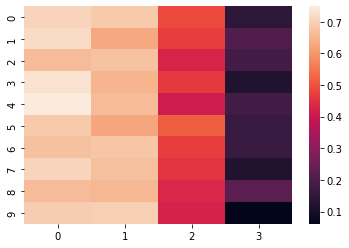

In [221]:
ax = sns.heatmap(class_acc)